In [1]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array, array_to_img

from keras import Model
from keras.layers import Dense, Flatten
from keras.optimizers import SGD
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
vgg = VGG16()

In [3]:
def predict_image_using_vgg(img_path, vgg):
    """
    Open image, convert it to an array, and run predictions
    using a trained model.
    """
    # load an image from file
    image = load_img(img_path, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape(
        (1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    y_pred = vgg.predict(image)
    labels = decode_predictions(y_pred)[0]
    for label in labels:
        print(label)
        

In [4]:
predict_image_using_vgg('../img/Dataset-32px/train/frog/cifar10-train-104.png', vgg)
# il s'agit d'un dataset avec des image trop petite (32x32) => nous avons abandonnait l'idée
# car les train sont deja reconnue et que la petite taille des images etait problematique pour un entrainement.

FileNotFoundError: [Errno 2] No such file or directory: '../img/Dataset-32px/train/frog/cifar10-train-104.png'

In [5]:
predict_image_using_vgg('../img/mug.jpg', vgg)

('n03063599', 'coffee_mug', 0.75265795)
('n03063689', 'coffeepot', 0.08366192)
('n07930864', 'cup', 0.06439695)
('n04398044', 'teapot', 0.030264096)
('n03950228', 'pitcher', 0.025892278)


### Creating a dataset

In [6]:
import os
import glob
import numpy as np

def create_dataset(folder):
    all_images = []
    image_arrays = []
    all_labels = []
    filenames = []
    for class_id, label in enumerate(os.listdir(folder)):
        print(class_id, label)
        for filename in glob.glob(folder + '/{}/*'.format(label)):
            filenames.append(filename)
            im = load_img(filename, target_size=(224, 224))
            all_images.append(im)
            preprocessed = preprocess_input(img_to_array(im))
            image_arrays.append(preprocessed)
            all_labels.append(class_id)
    X = np.array(image_arrays)
    Y = to_categorical(np.array(all_labels))
    return X, Y, filenames, all_images

In [46]:
X, Y, filenames, all_images = create_dataset('../img/dataset')

0 blimp
1 brain
2 doorknob


In [47]:
X.shape, Y.shape, len(filenames), len(all_images)

((262, 224, 224, 3), (262, 3), 262, 262)

('n02692877', 'airship', 0.98948866)
('n03888257', 'parachute', 0.0057357172)
('n02259212', 'leafhopper', 0.0014105382)
('n01910747', 'jellyfish', 0.00047697805)
('n04044716', 'radio_telescope', 0.00046646595)


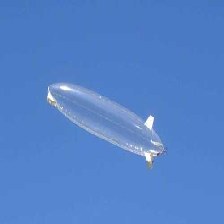

In [48]:
img_id = 29
predict_image_using_vgg(filenames[img_id], vgg)
all_images[img_id]
# ici nous erifion que l'image passé n'est pas dans une categorie deja existante de notre modele

####  TODO Commentaire sur le résultat de VGG16 (est-ce que les classes ont du sens pour notre example ou pas)

In [49]:
# Les classes présentées ici n'ont pas de sens pour notre exemple. En effet,
# ces dernières sont des classes généralistes et nous souhaitons différencier des
# objets qui n'y sont pas présentés
# De plus, l'exemple précédant illustre parfaitement ce problème, puisque l'on souhaite ici
# distinguer différent logo, et que le logo Adidas est interpreté comme un avion par VGG16.
# Il faut donc de nouvelles classes

# Edit : les classse presenté sont proche d'un bon resultat mais ont un probleme, 
# ce n'est pas un avion mais ça voledonc les classes n'ont pas de sens

### Transfer learning

In [50]:
# Charger VGG-16 pré-entraîné sur ImageNet
# mais sans les couches fully-connected
vgg_cut = VGG16(weights="imagenet", include_top=False,
                input_shape=(224, 224, 3))
x = vgg_cut.output
# transform matrix into 1-d vector
x = Flatten()(x)

# TODO essayer de modifier le nombre de neurones  
x = Dense(30, activation='relu')(x) 

# TODO parametrer le nombre de classes (9 ici)
nb_classes = 3
x = Dense(nb_classes, activation='softmax')(x)  



In [51]:
custom_model = Model(inputs=vgg_cut.input, outputs=x)

In [52]:
# stratégie de Transfer Learning: extraction de features
# On entraîne seulement le nouveau classificateur,
# et on NE ré-entraîne PAS les autres couches.
# On utilise les autres couches uniquement pour 
# extraire des features des images
for layer in custom_model.layers[:-2]:
    layer.trainable = False

In [53]:
custom_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [54]:
# Compiler le modèle 
custom_model.compile(
    loss="categorical_crossentropy",
    optimizer=SGD(lr=0.0001, momentum=0.9),
    metrics=["accuracy"])

In [55]:
# Entraîner sur toutes les données
# (X_train, Y_train)
custom_model.fit(X, Y,
                 epochs=3, batch_size=10)
# TODO essayer de changer epochs=3 (5, 10)

Epoch 1/3
262/262 [==============================] - 205s 781ms/step - loss: 1.9789 - acc: 0.8168
Epoch 2/3
262/262 [==============================] - 173s 659ms/step - loss: 0.4735 - acc: 0.9656
Epoch 3/3
262/262 [==============================] - 174s 663ms/step - loss: 0.3251 - acc: 0.9771


In [56]:
custom_model2 = Model(inputs=vgg_cut.input, outputs=x)
# ce modele permettra de comparer epochs=3 et epochs=5

In [57]:
for layer in custom_model2.layers[:-2]:
    layer.trainable = False

In [58]:
custom_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [59]:
# Compiler le modèle 
custom_model2.compile(
    loss="categorical_crossentropy",
    optimizer=SGD(lr=0.0001, momentum=0.9),
    metrics=["accuracy"])

In [60]:
# Entraîner sur toutes les données cette fois avec epochs=5
# (X_train, Y_train)
custom_model2.fit(X, Y,
                 epochs=5, batch_size=10)

Epoch 1/5
262/262 [==============================] - 170s 647ms/step - loss: 0.2432 - acc: 0.9847
Epoch 2/5
262/262 [==============================] - 172s 655ms/step - loss: 0.1604 - acc: 0.9885
Epoch 3/5
262/262 [==============================] - 173s 661ms/step - loss: 0.1347 - acc: 0.9885
Epoch 4/5
262/262 [==============================] - 172s 658ms/step - loss: 0.0076 - acc: 0.9962
Epoch 5/5
262/262 [==============================] - 173s 660ms/step - loss: 1.9929e-07 - acc: 1.0000


In [89]:
# il est inutile de tester avec epochs=10 car ce serait trop long et cela provoquerait un sur-apprentissage

#### Utilisons notre modèle entrainé pour faire des prédictions sur les images de test

In [35]:
# télécharger les images de test (sans libellé, tout dossier TEST)
def load_test_set(folder):
    all_images = []
    image_arrays = []
    filenames = []
    for filename in glob.glob(folder + '/*'):
        filenames.append(filename)
        im = load_img(filename, target_size=(224, 224))
        all_images.append(im)
        preprocessed = preprocess_input(img_to_array(im))
        image_arrays.append(preprocessed)
    X = np.array(image_arrays)
    return X, filenames, all_images

In [36]:
X_test, test_filenames, test_images = load_test_set(
    '../img/test/')

In [37]:
X_test.shape

(71, 224, 224, 3)

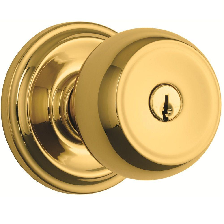

In [66]:
test_id = 14
test_images[test_id]
# on choisit l'image avec un identifiant

In [68]:
def decode(results):
    print("Blimp : " + str(round(results[0][0], 10)) + " ")
    print("Brain : " + str(round(results[0][1], 10)) + " ")
    print("Doorknob : " + str(round(results[0][2], 10)) + " ")
    print(results)

img_reshaped = X_test[test_id].reshape(1, *X_test[test_id].shape)
result_pred = custom_model.predict(img_reshaped)
decode(result_pred)
# il s'agit ici de faire la prediction avec l'image que l'on voit au dessus

Blimp : 0.0 
Brain : 0.0 
Doorknob : 1.0 
[[0.0000000e+00 2.0647342e-24 1.0000000e+00]]


####  TODO Commentaire sur le résultat des prédiction de notre modèle custom

In [95]:
# Les resultats sont correct, 
# le modele custom a su differencier correctement les images de dirigeable, de cerveau et de poignée de porte.


# Projet
1. Trouver le sujet de classification d'images
2. Créer le jeu de données:
    * Télécharger les images de l'Internet
    * Utiliser le plugin ""Download All Images"" de navigateur pour aller plus vite:
    * Saisir la requete sur Google Images (par exemple)
    * Cliquer sur "Download All Images" (le plugin du navigateur)
    * Dézipper le fichier téléchargé
    * Récupérer seulement des images pertinentes
    * Mettre ces images dans votre arboscence:
        "img/<nom_de_l_equipe>/<un_dossier_par_catégorie>/*.png"
    * Créer des matrices X et Y à partir des images:
        * itérateur sur les dossiers et les images;
        * chargement des images;
        * preprocessing lié à VGG16 (ou autre modèle CNN préentrainé que vous allez utiliser);
        * création du numpy.array finale depuis la liste des images chargés et prétraités;
        * création du vecteur de "labels" à partir des noms de dossiers parcourus, pour chaque image ("adidas adidas adidas cocacola cocacola fdj fdj fdj fdj ....");
        * conversion du vecteur 1-dimensionnel de labels en vecteur M-dimensionnel, où M = nombre de catégories de votre problème: pour cela, utiliser la fonction *to_categorical*. Chaque label doit donc être un vecteur avec des 0.0 et une seule valeur 1.0 sur la position qui correspond à la bonne catégorie.
        
3. Utiliser un des modèles CNN (convolutional neural network) déjà entrainé (comme VGG ou autre, cf. ici https://keras.io/applications/) pour faire des prédictions sur quelques images de votre dataset. Utiliser "decode_predictions" pour afficher à quelles classes appartient des valeurs maximales du vecteur de prédiction

* Comme votre use case est spécifique, et les classes présentes dans le modèle VGG ne correspondent pas à votre problème. Il faut donc faire du Transfer Learning:
    * Prendre un modèle pré-entrainé (VGG par exemple), mais ne pas utiliser sa dernière couche! (include_top=False). Ne pas oublier de spécifier le format des images en entrée ((224, 224, 3) pour VGG). 
    * Ajouter une couche Flatten() pour aplaitir la matrice pour obtenir le vecteur 1-dimensionnel.
    * Ajouter une couche Dense(nb_classes, activation="softmax")
    * Créer un modele *custom* qui va utiliser ces couches-là.
    * Comme le modèle VGG sera en version "cut" ("truncated"), donc elle ne sera pas utilisé pour les prédictions mais seulement pour extraction de features. Donc, il faut préciser que les couches du modèle custom soit déclarés comme "layer.trainable = False". Utiliser l'itérateur sur "custom_model.layers" afin de préciser quelles couches ne pas entrainer.
    * Vérifier avec "custom_model.summary()" que seulement les paramètres qui correspondent à la dernière couche Dense seront entrainés (cf. les messages "Total parameters, Trainable parameters, Non-Trainable parameters" du summary.
    * Déclarer la méthod de "compilation" du modèle (fonction de perte, algorithme, métrique) avec "custom_model.compile(....)"
    * Finalement, ENTRAINER le modèle avec la commande "custom_modèle.fit". Utiliser plusieurs nombre de *epochs* (plus est mieux, quitte à laisser le modèle s'entrainer pendant plusieurs heures); varier le *batch_size* en fonction de nombre totale d'images dans votre dataset (batch_size plus élevé accélère l'entrainement mais dégrade le résultat; par contre valeur 1 risque de finir par le "overfit", "surapprentissage", où le modèle va apprendre par coeur des exemple, mais mal généraliser sur des nouvelles images, donc le score sera mauvais aussi. Trouver la bonne valeur de batch_size, commenter les étapes de votre expérimentation.
    
    
* Charger des images depuis le dossier "img/test_images", utiliser le même prétraitement afin d'avoir le même format que des matrices X (pas besoin de Y ici, car vous allez juste lancer des prédictions).
* Lancer des prédictions sur ces nouvelles images (custom_model.predict).
* Interpréter des prédictions. Quelle catégorie donne la proba maximale?  Afficher l'image dans notebook pour voir ce qu'elle représente. Est-ce que c'est la bonne catégorie qui a été prédite?


#### Faire un résumé du projet: qu'est-ce que vous avez fait, quels résultats obtenus. Quel score a votre modèle, est-ce qu'elle prédit bien sur des images de test.
#### Commentez votre code!!! 
    
### livrables: GITHUB!!! code + images + requirements.txt, la même arborescence que dl MAIS SANS DOSSIER MYENV!!!  requirements.txt suffira pour recréer "myenv" lors de la correction

### denis.lazarenko@gmail.com


### deadline: 28 avril 2019 , 23:59:59
### questions par mail


#### Liens utils
* training Keras models: 
  https://keras.io/getting-started/sequential-model-guide/
* deep learning tutorial: https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/
* convolution filter produces a feature map (animation): https://www.youtube.com/watch?v=KiftWz544_8

In [96]:
#Nous avons fait dans ce projet:
# -nous avons chercher des lots d'images sur le site http://www.vision.caltech.edu/Image_Datasets/Caltech256/ 
# -nous avons verifier que le modele deja existant ne savait pas reconnaître 
#    les images choisis et ce pour pouvoir l'enrichire.
# -nous avons entrainé notre modele afin qu'il puisse reconnaitre les images de cerveau, 
#    de dirigeable et de poignée de porte.
# -nous avons enfin donner un banc de test avec toutes sortes d'images 
#    afin de verifier que l'apprentissage c'est bien déroulé.

# Nous somes donc satisfait du resultats car le modele reconnait bien les images passé,
# de plus il a une accuratie de 1.000 car les images sont bien varié. 
# A noter que la précision est très élévé ce qui signifie que le modele est peut-etre proche d'un "overfit"